In [1]:
from flask import Flask, render_template, request, jsonify , make_response , send_file
import re 
import ast
from flask_cors import CORS
import pandas as pd

app = Flask(__name__)
CORS(app)


In [2]:
from groq import Groq

client = Groq(
    api_key="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",
)
df = []
tst = ""
info = ""

In [3]:
def search_dataset(message) :
    # Search DATASET ...,

    chat_completion = client.chat.completions.create(
    messages=[
        {
            "role": "user",
            "content": f"{message} , Provide me top 5 links from kaggle to download the dataset , be precise" ,
        }
    ],
    model="llama3-70b-8192",
    )
    response_text = chat_completion.choices[0].message.content
    print(response_text)
    return response_text


In [4]:
def preprocess(mess) :

    chat_completion = client.chat.completions.create(
        messages=[
            {
                "role": "user",
                "content": f"This is the dataset i have : {tst} , give a code to {mess} also call it , give code only dont give explanation , do all in inplace so that it updates in realtime" ,
            }
        ],
        model="llama3-70b-8192",
        )
    
    akn = client.chat.completions.create(
        messages=[
            {
        "role": "user",
        "content": "Write a success aknowledgement message in 3 lines for {mess}" ,
    }
        ],
        model="llama3-70b-8192",
        )
    viss = chat_completion.choices[0].message.content
    viss =  re.sub('python', '', viss)
    viss =  re.sub('Python', '', viss)
    
    print(viss)
    pattern = r"```(.*?)```"

    # Find all matches
    matches = re.findall(pattern, viss, re.DOTALL)

    # Safely parse the response text as a Python AST (Abstract Syntax Tree)
    parsed_ast = ast.parse(matches[0])

    # else:
    # Execute the parsed AST
    exec(compile(parsed_ast, filename="<ast>", mode="exec"))
    
    return akn.choices[0].message.content


In [5]:
@app.route('/process_file', methods=['POST'])
def process_file():
    global info 
    global df
    global tst 
    file = request.files['file']
    if file:
        file.save('data.csv')
        df = pd.read_csv('data.csv')
        tst = df.head()
        info = df.info()
        chat_completion = client.chat.completions.create(
        messages=[
            {
                "role": "user",
                "content": f"This is the dataset i have : {tst} , explain and summarize it in 2 lines" ,
            }
        ],
        model="llama3-70b-8192",
        )
        response_text = chat_completion.choices[0].message.content
        print(response_text)
        return jsonify({'response': response_text})
    else:
        return jsonify({'response': 'No file provided'})




In [6]:
# # # Process CSV 
# # @app.route('/process_data', methods=['POST'])

# def process_csv () :
#     global df
#     path = ""
#     df = pd.read_csv(path)
#     chat_completion = client.chat.completions.create(
#     messages=[
#         {
#             "role": "user",
#             "content": f"This is the dataset i have : {tst} , explain and summarize it in 2 lines" ,
#         }
#     ],
#     model="llama3-8b-8192",
#     )
#     response_text = chat_completion.choices[0].message.content
#     print(response_text)


In [7]:
def suggest() :
    # Suggessions

    chat_completion = client.chat.completions.create(
    messages=[
        {
            "role": "user",
            "content": f"I'm working on preprocessing a DataSet ,  This is the dataset i have : {tst} and its info : {info},give me 3 suggests to what to do further in 3 lines" ,
        }
    ],
    model="llama3-70b-8192",
    )
    response_text = chat_completion.choices[0].message.content
    return response_text

In [8]:
def others(mess) :

    chat_completion = client.chat.completions.create(
    messages=[
        {
            "role": "user",
            "content": f"You are a AI data analyst , answer the below question according to your role , QUESTION : {mess}" ,
        }
    ],
    model="llama3-70b-8192",
    )
    response_text = chat_completion.choices[0].message.content
    return response_text

In [9]:
cnt=1

In [10]:
def visualize(mess) :
    # Visualize 
    global cnt
    chat_completion = client.chat.completions.create(
    messages=[
        {
            "role": "user",
            # "content": f"This is the dataset i have : {tst} , give a code to visualize column1 and column2 also call it ,mention the column names exactly , give code only dont give explanation " ,
            "content": f"This is the dataset i have : {tst} , give a code to visualize {mess}using matplotlib , also call it ,give the column names exactly as in the dataset give clean code also save the plot as 'plot{cnt}.png' "
        }
    ],
    model="llama3-70b-8192",
    )
    viss = chat_completion.choices[0].message.content
    viss =  re.sub('python', '', viss)
    viss =  re.sub('Python', '', viss)
    pattern = r"```(.*?)```"

    # Find all matches
    matches = re.findall(pattern, viss, re.DOTALL)

    # Safely parse the response text as a Python AST (Abstract Syntax Tree)
    parsed_ast = ast.parse(matches[0])

    # else:
    # Execute the parsed AST
    exec(compile(parsed_ast, filename="<ast>", mode="exec"))
    
    return f"C:/Prodigy/DataGenie/plot{cnt}.png"



In [11]:

@app.route('/')
def index():
    return render_template('index.html')

@app.route('/send_message', methods=['POST'])
def send_message():
    global cnt
    message = request.get_json()['message']
    if "visualize" in message.lower() or "plot" in message.lower() :
        res = visualize(message)
        cnt += 1
        return jsonify({'response': "image" , "path" : res})
    response = process_message(message)
    return jsonify({'response': response })

def process_message(message):
    # Implement your chatbot logic here
    res = ""
    if "search a dataset" in message.lower() :
        res = search_dataset(message)
        # return res

        # return res
    if 'preprocess' in message.lower() or 'clean' in message.lower() :
        res = preprocess(message)
        # return res
    if 'suggest' in message.lower() or 'next' in message.lower() :
        res = suggest()
        # return res
    else :
        res = others(message)
        
    return res
    return "image"


In [12]:
@app.route('/download', methods=['GET'])
def download_csv():
    # Convert the DataFrame to a CSV string
    csv_string = df.to_csv(index=False)

    # Set the response headers
    response = make_response(csv_string)
    response.headers['Content-Disposition'] = 'attachment; filename="data.csv"'
    response.headers['Content-Type'] = 'text/csv'

    return response

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:7000
Press CTRL+C to quit
127.0.0.1 - - [03/Jul/2024 19:19:26] "OPTIONS /send_message HTTP/1.1" 200 -


Here are the top 5 links from Kaggle to download datasets for heart disease classification:

1. **Heart Disease UCI**: This dataset from the University of California, Irvine (UCI) contains 303 instances with 14 attributes, including age, sex, chest pain type, and more. [Download](https://www.kaggle.com/uciml/heart-disease-data)
2. **Heart Failure Prediction**: This dataset contains 299 records with 13 features, including age, sex, blood pressure, and more, to predict heart failure. [Download](https://www.kaggle.com/andrewmvd/heart-failure-prediction)
3. **Cardiovascular Disease Dataset**: This dataset from the Cleveland Clinic Foundation contains 303 instances with 13 attributes, including age, sex, cholesterol levels, and more. [Download](https://www.kaggle.com/kamilpytel/cardiovascular-disease-dataset)
4. **Heart Disease Classification**: This dataset contains 918 records with 12 features, including age, sex, blood pressure, and more, to classify heart disease into different categori

127.0.0.1 - - [03/Jul/2024 19:19:31] "POST /send_message HTTP/1.1" 200 -
127.0.0.1 - - [03/Jul/2024 19:20:13] "OPTIONS /send_message HTTP/1.1" 200 -


Here are the top 5 Kaggle datasets for heart disease classification with download links:

1. **Heart Disease UCI**:
	* Dataset size: 303 rows, 14 columns
	* Description: This dataset contains 13 features and 1 target variable to predict the presence of heart disease.
	* Link: https://www.kaggle.com/uciml/heart-disease
2. **Cardiovascular Disease Dataset**:
	* Dataset size: 70000 rows, 13 columns
	* Description: This dataset contains demographic, behavioral, and medical characteristics of patients to predict the presence of cardiovascular disease.
	* Link: https://www.kaggle.com/sulianov/cardiovascular-disease-dataset
3. **Heart Failure Clinical Records**:
	* Dataset size: 299 rows, 13 columns
	* Description: This dataset contains clinical records of heart failure patients, including demographics, medical history, and laboratory results.
	* Link: https://www.kaggle.com/andrewmvd/heart-failure-clinical-records
4. **Heart Disease Prediction**:
	* Dataset size: 918 rows, 13 columns
	* Desc

127.0.0.1 - - [03/Jul/2024 19:20:22] "POST /send_message HTTP/1.1" 200 -


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   Alcohol_value   34 non-null     int64
 1    Methane_value  34 non-null     int64
 2    Temperature    34 non-null     int64
 3    Humidity       34 non-null     int64
dtypes: int64(4)
memory usage: 1.2 KB


127.0.0.1 - - [03/Jul/2024 19:20:50] "POST /process_file HTTP/1.1" 200 -


Here is a 2-line summary of your dataset:

This dataset appears to be sensor readings for various environmental conditions, including alcohol and methane levels, temperature, and humidity, with 5 samples recorded. The values vary across the samples, but no obvious patterns or correlations jump out initially.


127.0.0.1 - - [03/Jul/2024 19:21:40] "OPTIONS /send_message HTTP/1.1" 200 -
127.0.0.1 - - [03/Jul/2024 19:21:41] "POST /send_message HTTP/1.1" 200 -
127.0.0.1 - - [03/Jul/2024 19:22:08] "OPTIONS /send_message HTTP/1.1" 200 -


Here is the code to preprocess the dataset:
```
import pandas as pd
import numpy as np

df = pd.DataFrame({
    'Alcohol_value': [366, 407, 421, 460, 278],
    'Methane_value': [364, 411, 429, 442, 304],
    'Temperature': [39, 39, 40, 41, 29],
    'Humidity': [41, 44, 44, 65, 38]
})

# Remove null values
df.fillna(df.mean(), inplace=True)
```
Note: I assume that the missing values will be replaced with the mean of the respective column. If you want to replace with median or mode, you can use `df.fillna(df.median(), inplace=True)` or `df.fillna(df.mode().iloc[0], inplace=True)` respectively.


127.0.0.1 - - [03/Jul/2024 19:22:12] "POST /send_message HTTP/1.1" 200 -
127.0.0.1 - - [03/Jul/2024 19:22:36] "OPTIONS /send_message HTTP/1.1" 200 -


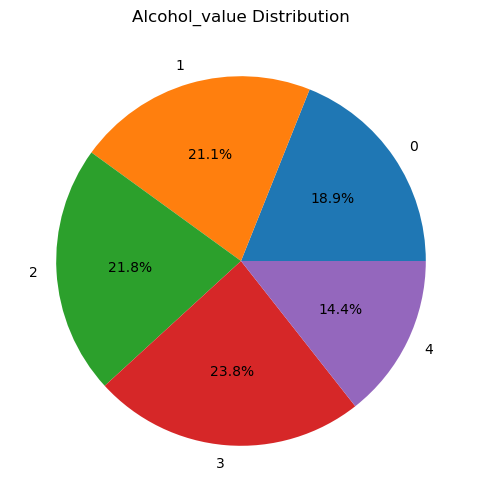

<Figure size 640x480 with 0 Axes>

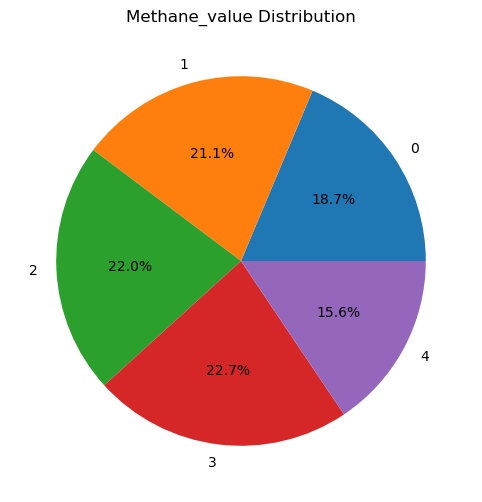

<Figure size 640x480 with 0 Axes>

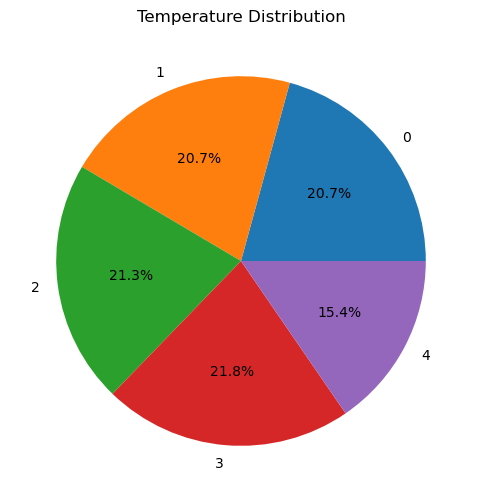

<Figure size 640x480 with 0 Axes>

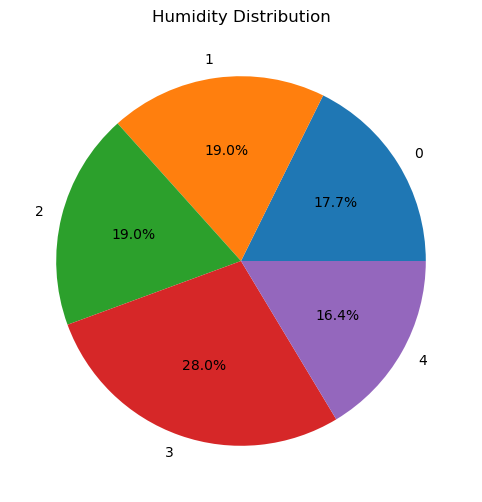

127.0.0.1 - - [03/Jul/2024 19:22:42] "POST /send_message HTTP/1.1" 200 -
127.0.0.1 - - [03/Jul/2024 19:22:53] "OPTIONS /send_message HTTP/1.1" 200 -


<Figure size 640x480 with 0 Axes>

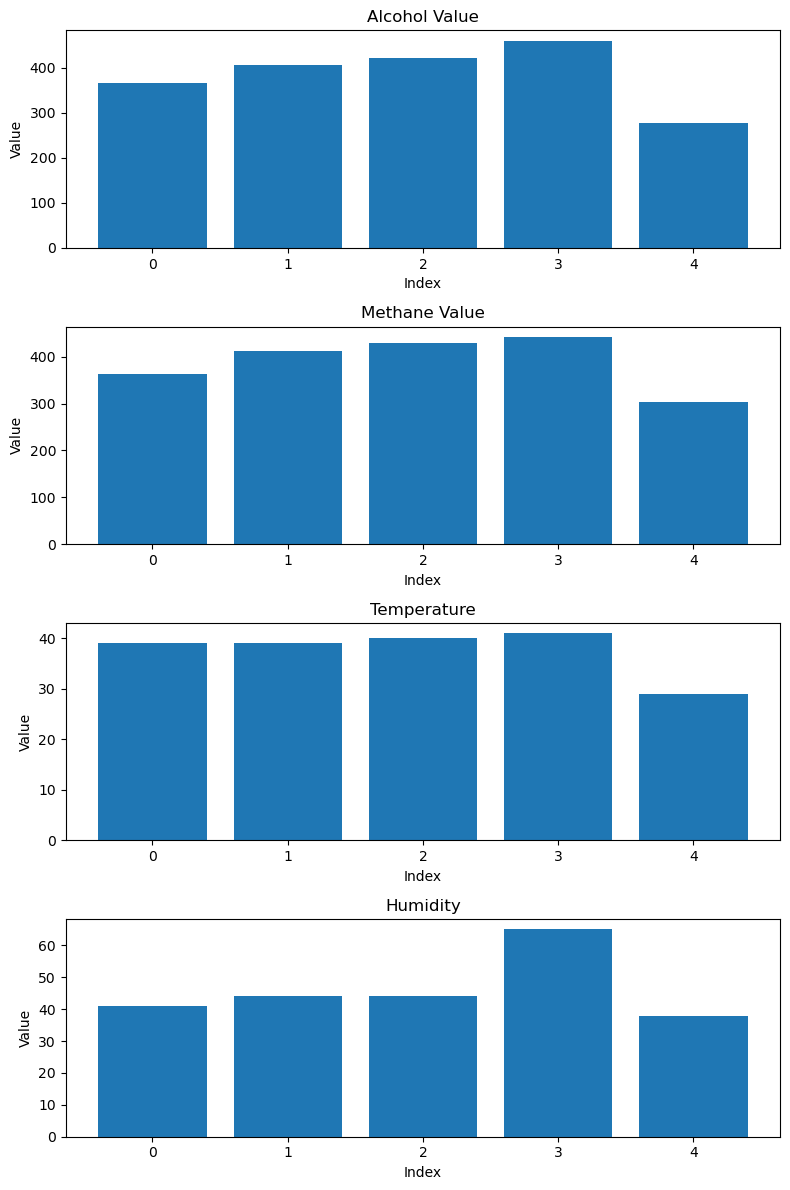

127.0.0.1 - - [03/Jul/2024 19:22:58] "POST /send_message HTTP/1.1" 200 -
127.0.0.1 - - [03/Jul/2024 19:24:12] "OPTIONS /send_message HTTP/1.1" 200 -


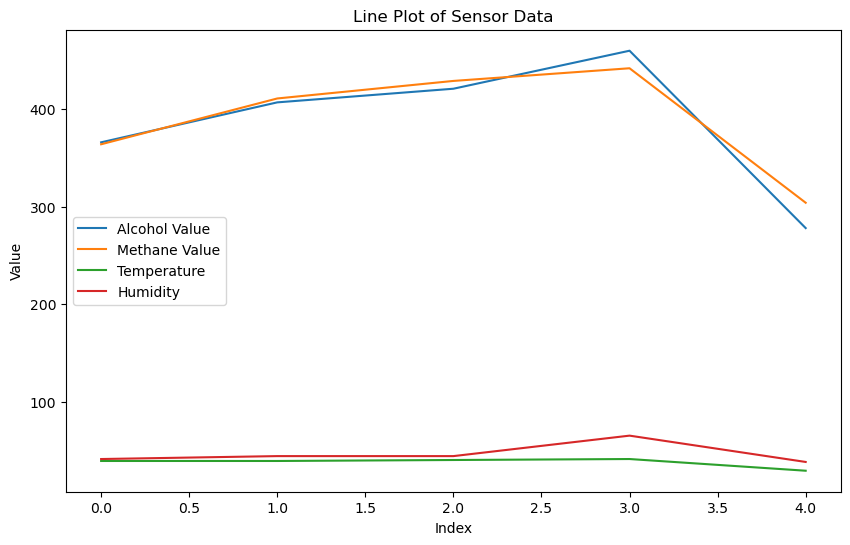

127.0.0.1 - - [03/Jul/2024 19:24:15] "POST /send_message HTTP/1.1" 200 -
127.0.0.1 - - [03/Jul/2024 19:24:48] "OPTIONS /download HTTP/1.1" 200 -
127.0.0.1 - - [03/Jul/2024 19:24:48] "GET /download HTTP/1.1" 200 -


In [13]:
if __name__ == '__main__':
    app.run(port=7000)
